# Travelling Salesman Problem

Amplify を用いた巡回セールスマン問題の解法について解説します。

## 巡回セールスマン問題の定式化

[巡回セールスマン問題](https://en.wikipedia.org/wiki/Travelling_salesman_problem) とは、都市の集合とそれぞれの都市間の距離が与えられたときに、全ての都市を通る巡回路において移動距離の合計が最小となる経路を求める組合せ最適化問題です。


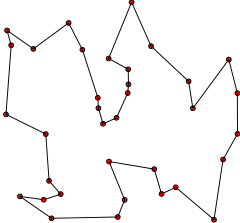

イジングマシンを用いるためには巡回路の組合せを二値多変数多項式で表す必要があります。全ての経路の組合せは、どの都市を何番目に通ったかを表す変数テーブルによって表現することが出来ます。例えば4都市について次のような表を用意することで、経路 $A→C→B→D$ が表現されます。

| turn| A | B | C | D |
|-----|---|---|---|---|
| 1st | 1 | 0 | 0 | 0 |
| 2nd | 0 | 0 | 1 | 0 |
| 3rd | 0 | 1 | 0 | 0 |
| 4th | 0 | 0 | 0 | 1 |

表の各要素に変数 ${0,1}$ を割り当て、ある経路の順番について $1$ となる変数に対応する都市を通ると解釈します。すなわち、$N$ 都市の巡回セールスマン問題については $N^2$ の変数を用意すれば良いです。

上記の表における各変数を経路の順番 $n$ と都市のインデックス $i$ を用いて、$q_{n,i}$ と表すことにします。すると全移動経路は、

$$
 \sum_{n=0}^{N-1}{\sum_{i=0}^{N-1}{\sum_{j=0}^{N-1}{ d_{ij} q_{n, i} q_{n+1, j} }}}
$$

で表されます。ここで $d_{ij}$ は都市 $i$ と都市 $j$ の間の移動距離です。

$d_{ij} q_{n, i} q_{n+1, j}$ は両方の変数が $1$ になる時に $d_{ij}$ を加算するので、移動距離の合計を最小化する問題になっています。後でプログラムコード化する都合により、インデックスは $0$ からスタートしていることに注意してください。また、$n+1$ の最後 ( $N$ ) は始点に戻るため $N$ で剰余を取る事にします。

しかしこれだけでは定式化として不十分です。なぜなら、上記の変数テーブルは「全ての都市を通る」という制約と「同時に一つだけ通る」という制約が考慮されていないためです。極端な例として、最初の都市から動かないという組合せも許されています。そこで変数テーブルの全ての行と列に対して次のような制約を課します。

$$
    \sum_{i=0}^{N-1}{q_{n, i}} = 1 \quad n \in \left\{0, 1, \cdots, N - 1 \right\}
$$
$$
    \sum_{n=0}^{N-1}{q_{n, i}} = 1 \quad i \in \left\{0, 1, \cdots, N - 1 \right\}
$$

これは変数テーブルの取り得る値のうち、各行と各列に $1$ が一回しか現れない制約を意味します。

上記をまとめると、次の二値多変数多項式の最小値を求めれば良いことがわかりました。

- コスト関数
$$
\sum_{n=0}^{N-1}{\sum_{i=0}^{N-1}{\sum_{j=0}^{N-1}{ d_{ij} q_{n, i} q_{n+1, j} }}}
$$

- 制約条件
$$
    \sum_{i=0}^{N-1}{q_{n, i}} = 1 \quad n \in \left\{0, 1, \cdots, N - 1 \right\}
$$
$$
    \sum_{n=0}^{N-1}{q_{n, i}} = 1 \quad i \in \left\{0, 1, \cdots, N - 1 \right\}
$$


## 問題の生成

まず巡回セールスマン問題の入力となる、各都市間の距離を作成します。ここでは `numpy` を用いて、二次元平面上のランダムな位置に都市を配置して距離行列を生成します。次のように、都市数を与えることでランダムな巡回セールスマン問題を生成する関数を作成しました。

In [ ]:
import numpy as np


def gen_random_tsp(ncity: int):
    # 座標
    locations = np.random.uniform(size=(ncity, 2))

    # 距離行列
    all_diffs = np.expand_dims(locations, axis=1) - np.expand_dims(locations, axis=0)
    distances = np.sqrt(np.sum(all_diffs**2, axis=-1))

    return locations, distances

`gen_random_tsp` 関数の二つ目の返値である、`distances` は上記定式化における $d$ に相当します。

次のようにして $32$ 都市について各都市の座標がプロットされます。

In [ ]:
import matplotlib.pyplot as plt


def show_plot(locs: np.ndarray):
    plt.figure(figsize=(7, 7))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.scatter(*zip(*locations))
    plt.show()


ncity = 32
locations, distances = gen_random_tsp(ncity)

In [ ]:
show_plot(locations)

## 二値多項式模型の構築

次に変数テーブルを作成します。これが巡回路における訪問順と訪問先を表します。

In [ ]:
from amplify import BinarySymbolGenerator

gen = BinarySymbolGenerator()
q = gen.array(ncity, ncity)

変数テーブルは次のように二値変数を各要素に持つサイズ $N×N$ の二次元配列です。

In [ ]:
q_4city = BinarySymbolGenerator().array(4, 4)
q_4city  # 4都市の場合の実行例

これを用いてコスト関数を作成します。

In [ ]:
from amplify import einsum

cost = einsum("ij,ni,nj->", distances, q, q.roll(-1, axis=0))

コスト関数における和の演算に対して補助関数の `einsum` 関数を用いています。`einsum("ij,ni,nj->", d, q, q.roll(-1, axis=0))` は $\sum_{n = 0}^{N - 1}{d_{ij}q_{n,i} q_{n+1,j}}$ に対応します。`q.roll(-1, axis=0)` で `n` のインデックスをずらしていることに注意してください。

### Note

和の演算を表す `sum_poly` 関数を用いると、次のように書くことも可能です。

```python
cost = sum_poly(
    ncity,
    lambda n: sum_poly(
        ncity,
        lambda i: sum_poly(
            ncity, lambda j: distances[i, j] * q[n, i] * q[(n + 1) % ncity, j]
        ),
    ),
)
```

次に制約条件を構築します。One-hot 制約は `one_hot()` 関数で作成されます。`sum()` 関数で全ての制約条件を足し合わせます。

In [ ]:
from amplify.constraint import one_hot
from amplify import sum_poly

# 行に対する制約
row_constraints = [one_hot(q[n]) for n in range(ncity)]

# 列に対する制約
col_constraints = [one_hot(q[:, i]) for i in range(ncity)]

constraints = sum(row_constraints) + sum(col_constraints)

最後にコスト関数と全ての制約条件を足し合わせて論理模型オブジェクトを作成します。ここで制約条件の強さに注意を要する必要があります。適切な制約条件の強さはコスト関数に依存し、十分に大きな値にする必要があるからです。しかし一方で、制約の強さを可能な限り小さくすることで、イジングマシンが出力する結果が改善する傾向にもあります。

巡回セールスマン問題における制約条件の強さに関する議論はリファレンス [1] を参照してください。ここでは、十分な大きな値として距離行列の最大値を設定します。この値を用いて次のように論理模型オブジェクトを作成します。

In [ ]:
constraints *= np.amax(distances)  # 制約条件の強さを設定
model = cost + constraints


[1]: [K. Takehara, D. Oku, Y. Matsuda, S. Tanaka and N. Togawa, "A Multiple Coefficients Trial Method to Solve Combinatorial Optimization Problems for Simulated-annealing-based Ising Machines," 2019 IEEE 9th International Conference on Consumer Electronics (ICCE-Berlin), Berlin, Germany, 2019, pp. 64-69, doi: 10.1109/ICCE-Berlin47944.2019.8966167.](https://ieeexplore.ieee.org/abstract/document/8966167)


## イジングマシンの実行

イジングマシンのクライアントを作成しパラメータを設定します。その後ソルバーを作成しクライアントを設定します。

In [ ]:
from amplify import Solver
from amplify.client import FixstarsClient

client = FixstarsClient()
client.parameters.timeout = 5000  # タイムアウト5秒

solver = Solver(client)

次のようにしてイジングマシンを実行し結果を取得します。

In [ ]:
result = solver.solve(model)
if len(result) == 0:
    raise RuntimeError("Any one of constraints is not satisfied.")

energy, values = result[0].energy, result[0].values

### Note

もし `result` オブジェクトが空の場合、制約条件を満たす解が得られなかったことを意味します。
この場合はイジングマシンのパラメータや制約の強さの変更が必要です。

## 結果の解析

`energy` はコスト関数の評価値を表します。今回の定式化では移動距離の合計に相当します。

In [ ]:
energy

`values` は入力変数と解の値のマッピングを表す辞書です。そのままでは評価しづらいので、次のようにデコードメソッドを用いて変数テーブル `q` と同一の形式にデコードします。

In [ ]:
q_values = q.decode(values)

```python
>>> q_values # 4都市の場合の実行例
[[1, 0, 0, 0],
 [0, 0, 0, 1],
 [0, 0, 1, 0],
 [0, 1, 0, 0]]
```

これを見ると、各行・各列に $1$ が一回ずつしか現れていないため、確かに制約条件を満たしていることがわかります。 $1$ が現れる列インデックスを取得すれば経路がわかるので、次のように `numpy` 関数を用いて調べます (`numpy` の関数を使用するために配列 `numpy.ndarray` に変換しています)。

In [ ]:
route = np.where(np.array(q_values) == 1)[1]
print(route)

最後に得られた経路を表示します。次の関数でプロットできます。

In [ ]:
def show_route(route: list, distances: np.ndarray, locations: np.ndarray):
    ncity = len(route)
    path_length = sum(
        [distances[route[i]][route[(i + 1) % ncity]] for i in range(ncity)]
    )

    x = [i[0] for i in locations]
    y = [i[1] for i in locations]
    plt.figure(figsize=(7, 7))
    plt.title(f"path length: {path_length}")
    plt.xlabel("x")
    plt.ylabel("y")

    for i in range(ncity):
        r = route[i]
        n = route[(i + 1) % ncity]
        plt.plot([x[r], x[n]], [y[r], y[n]], "b-")
    plt.plot(x, y, "ro")
    plt.show()

    return path_length

In [ ]:
show_route(route, distances, locations)

## 高度なチューニング

巡回セールスマン問題をイジングマシンで解く場合のテクニックをいくつか紹介します。

### 制約の強さの調整

一般にイジングマシンにおいて、制約の強さは小さい方が良い解が出る傾向にあります。定性的には、これは最小化したいコスト関数に対し、制約項を弱くした方が相対的にコスト項が重視されると説明されます。

リファレンス [1] によると制約の強さの下限値は、最適解の経路に含まれる都市間の最長距離という事がわかっていますが、一般にこれは事前に最適解がわからないため非自明です。そこで制約の強さの調整が必要になります。

よりよい解を求めるためには、上記のコードにおいてパラメータ $k \left( 0 < k \le 1 \right)$ を導入し、適切な下限値を見つけることが有効です。


In [ ]:
k = 0.5
model = cost + constraints * k * np.amax(distances)

アニーリング実行時間等を長くするよりも、複数の $k$ で実行する方が、同じ解の品質で比較した場合に、総合的には効率が良い場合もあります [1]。

次の実行例は $k=0.3$ から $k = 1.0$ まで $0.1$ 刻みで変化させた場合の解の様子です。$k$ が小さい方が品質の高い解が得られている傾向がわかります。


In [ ]:
client.parameters.timeout = 1000  # タイムアウト1秒
solver = Solver(client)

for i in range(2, 10):
    k = 0.1 * (i + 1)
    model = cost + constraints * k * np.amax(distances)
    result = solver.solve(model)

    print(f"k={k}")
    if len(result) == 0:
        print(f"Any one of constraints is not satisfied.")
        continue

    energy, values = result[0].energy, result[0].values

    q_values = q.decode(values)
    route = np.where(np.array(q_values) == 1)[1]
    show_route(route, distances, locations)

### Note

問題によっては、$k=1.0$でも十分品質の良い解が得られる場合もあります。

### コスト関数の縮小

制約項の強さの下限値はコスト関数項に依存し、その値は最適解の経路に含まれる都市間の最長距離が対応します。これはコスト関数における係数 $d_{ij}$ の大きさに依存していると解釈することも出来ます。もし、$d_{ij}$ の大きさを縮小することが出来れば、相対的に制約項をさらに小さくすることが可能になり、より品質の高い解が得られることを期待できます。

そこで都市 $i$ と 都市 $j$ の距離の定義を改変します。

$$
d_{ij}' = d_{ij} - \min_{j \ne i} d_{ij}
$$


都市 $i$ に着目したときに、最も近い別の都市の距離だけ縮めています。これにより $d_{ij}$ を全体的に縮小できます。距離行列の非対角項は $d_{ij} \ne d_{ji}$ となるため非対称巡回セールスマン問題となっています。

よってコスト関数は次のように変更されます。

$$
\sum_{n=0}^{N-1}{\sum_{i=0}^{N-1}{\sum_{j=0}^{N-1}{ d_{ij}' q_{n, i} q_{n+1, j} }}} + \sum_{i=0}^{N-1}{\min_{j \ne i} d_{ij}}
$$

定数項を追加し各都市において差し引いた分を全て足しています。経路は必ず1カ所を1回だけ通るので、これにより元のコスト関数と同一の値を取ります。

コードは次のように改変されます。

In [ ]:
# 各行の非ゼロ最小値をリストで取得
d_min = np.array(
    [(distances[n][distances[n].nonzero()]).min() for n in range(ncity)]
).reshape(ncity, 1)

# コスト関数の係数を改変し定数項を加算
new_cost = einsum("ij,ni,nj->", (distances - d_min), q, q.roll(-1, axis=0)) + sum(d_min)

# 各行の最小値を引いた上で全要素の最大値を取得
new_model = new_cost + constraints * np.amax(distances - d_min)

次の実行例はマシンパラメータを同一の条件に固定し、制約を満たす最小の $k$ における解の比較を行ったものです。左図はコスト関数変更する前で右図はコスト関数を変更した後です。解の品質が改善していることがわかります。

In [ ]:
# コスト関数変更前
for i in range(10):
    k = 0.05 * (i + 1)
    model = cost + constraints * k * np.amax(distances)
    result = solver.solve(model)

    print(f"k={k}")
    if len(result) == 0:
        print(f"Any one of constraints is not satisfied.")
        continue
    else:  # 制約を満たす解を得られたら終了
        q_values = q.decode(result[0].values)
        route = np.where(np.array(q_values) == 1)[1]
        show_route(route, distances, locations)
        break

In [ ]:
# コスト関数変更後
for i in range(10):
    k = 0.05 * (i + 1)
    new_model = new_cost + constraints * k * np.amax(distances - d_min)
    result = solver.solve(new_model)

    print(f"k={k}")
    if len(result) == 0:
        print(f"Any one of constraints is not satisfied.")
        continue
    else:  # 制約を満たす解を得られたら終了
        q_values = q.decode(result[0].values)
        route = np.where(np.array(q_values) == 1)[1]
        show_route(route, distances, locations)
        break

### 回転対称性の除去

このセクションで紹介した定式化は解空間において冗長な部分があります。つまり同一の経路に対して複数の解の状態を持ちます。

具体的にはある経路に対して始点を定めていないために回転対称性を持ちます。また後述する右回り・左回り経路の反転対称性も持ちます。結果として、同一の経路に対し $2N$ 通りの解の状態が存在します。まずは始点を固定することで問題を縮約化し必要となる変数の数が少なくなるように試みます。

始点を固定化するには、あらかじめそのような状況を考慮して定式化することも出来ますが、事前に変数に値を入れておくことで、これまでの定式化から最小限の変更で行う事が可能です。

変数テーブルには値を代入することが可能なので、例えば最初に訪れる都市を $i=0$ に固定化します。つまり、

$$
    q_{0, 0} = 1 \\
    q_{0, i} = 0 \quad \left( i \ne 0 \right) \\
    q_{n, 0} = 0 \quad \left( n \ne 0 \right)
$$

を設定すれば良いです。これは次のようにします。

In [ ]:
# 変数テーブルの作成
gen = BinarySymbolGenerator()
q = gen.array(ncity, ncity)

# 変数テーブルの要素に値を設定
q[0, 0] = 1
for i in range(1, ncity):
    q[0, i] = 0
    q[i, 0] = 0

In [ ]:
q

以降は変更の必要はなくコスト関数と制約項の構築をこれまで通り進めてください。

これにより $N^2$ 変数の問題を $\left( N - 1 \right)^2$ 変数に縮小することが出来ました。

変数の数を減少させることで多少ながら解の品質の向上が期待できます。

### 反転対称性の除去

反転対称性については新たに制約を加えることで実現されます。制約の追加は問題の複雑化に繋がるため、必ずしも解の品質の向上に繋がるわけではないですが、参考のため解説します。

始点を $i = 0$ に固定化した上で、例えば経路 ``[0 2 4 3 6 5 1 7]`` が得られたとします。現在の定式化では、これを反転した ``[0 7 1 5 6 3 4 2]`` もまた同一の解です。この対称性を破るには、始点の次と前の都市のインデックスに着目します。前者の解では、$i = 2 \left(n=1 \right) < 7 \left(n=7 \right)$  ですが、後者では $i = 7 \left(n=1 \right) > 2 \left(n=7 \right)$ と不等号が反転しています。

この不等号を固定化すれば反転対称性を破ることが出来ます。前者のように $n = 1, N - 1$ で昇順になるようにするには、次の制約条件を追加します。

**制約条件 (追加)**

$$
q_{N-1,i} q_{1,j} = 0 \quad \left( i < j \right)
$$

この式は $i < j$ において $q_{N-1,i}, q_{1,j}$ が共に $1$ となることを禁止しています。このように最小値0をとる制約については、 `amplify.constraint.penalty` 関数を用いて次のように書けます。


In [ ]:
from amplify.constraint import penalty

# 順序に対する制約
pem_constraint = [
    penalty(q[ncity - 1, i] * q[1, j])
    for i in range(ncity)
    for j in range(i + 1, ncity)
]

# 行に対する制約
row_constraints = [one_hot(q[n]) for n in range(ncity)]

# 列に対する制約
col_constraints = [one_hot(q[:, i]) for i in range(ncity)]

constraints = sum(row_constraints) + sum(col_constraints) + sum(pem_constraint)

### Note

最小値0をとる制約条件については、先に全ての条件の和を取ってから単一の制約条件オブジェクトを作成しても等価です。この場合、ペアの組合せの和を表す `pair_sum` 関数を用いると次のように書けます。

```python
from amplify import pair_sum

# 順序に対する制約
pem_constraint = penalty(pair_sum(ncity, lambda i, j: q[ncity - 1, i] * q[1, j]))

constraints = sum(row_constraints) + sum(col_constraints) + pem_constraint
```


`amplify.pair_sum` 関数は $i<j$ について和を取るため `for` ループが不要になります。

行と列に対する制約条件と同様に、順序制約についても和を取り、最後に全ての制約条件を足し合わせます。以降はこれまでと同様に解を取得することで、$n = 1, N - 1$ で経路インデックスが昇順になっていることが確認できます。

In [ ]:
k = 1.0

# 各行の非ゼロ最小値をリストで取得
d_min = np.array(
    [(distances[n][distances[n].nonzero()]).min() for n in range(ncity)]
).reshape(ncity, 1)

# コスト関数の係数を改変し定数項を加算
cost = einsum("ij,ni,nj->", (distances - d_min), q, q.roll(-1, axis=0)) + sum(d_min)

model = cost + constraints * k * np.amax(distances - d_min)
result = solver.solve(model)

q_values = q.decode(result[0].values)
route = np.where(np.array(q_values) == 1)[1]
print(route)
show_route(route, distances, locations)